# Breakout: Exploring Machine Learning

In this breakout, we'll explore the use of scikit-learn on some astronomical data.

This will use [astroML](http://astroML.org), a package for machine learning in astronomy which includes several convenient loaders for various astronomical datasets.

Recall that if you don't have ``astroML`` installed, you can install it easily from the command-line with ``pip``:

```
$ pip install astroML
```

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
# If this causes an error, you can comment it out.
import seaborn as sns
sns.set()

## 1. Classification: Labeling Photometric Sources

Here we'll do some automated classification of photometric sources.
First the data, which can be fetched via ``astroML``.  If you don't have
astroML installed, use ``pip install astroML``

In [17]:
from astroML.datasets import fetch_rrlyrae_combined
from sklearn.model_selection import train_test_split

X, y = fetch_rrlyrae_combined()

# For now, we'll only fit the first two colors
X_train, X_test, y_train, y_test = train_test_split(X, y)

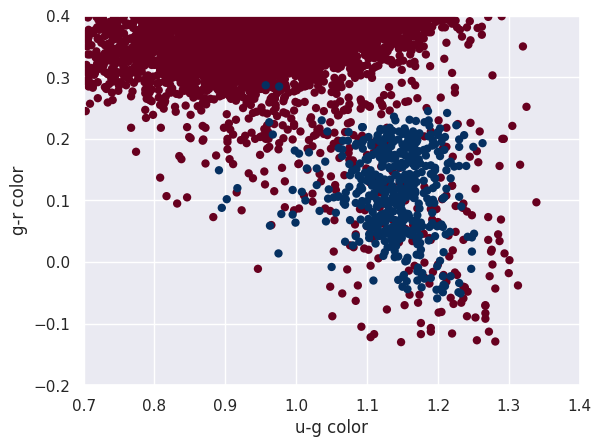

In [18]:
N_plot = 5000
plt.scatter(X[-N_plot:, 0], X[-N_plot:, 1], c=y[-N_plot:],
            edgecolors='none', cmap='RdBu')
plt.xlabel('u-g color')
plt.ylabel('g-r color')
plt.xlim(0.7, 1.4)
plt.ylim(-0.2, 0.4);

Blue points are RR-Lyrae, Red points are main sequence stars.

Now we'll do a simple and fast $K$-neighbors classification.

Note that we train on part of the data and test on another part.  Otherwise,
an estimator which simply remembers the entire dataset would obtain a perfect
classification!

In [19]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Now let's check how we're doing. You might be tempted to simply check the accuracy: i.e. in what fraction of points the predictions match the true value. Let's see this:

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9966503478484926

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,
                            target_names=['MS star', 'RR Lyrae']))

              precision    recall  f1-score   support

     MS star       1.00      1.00      1.00     23174
    RR Lyrae       0.68      0.57      0.62       112

    accuracy                           1.00     23286
   macro avg       0.84      0.79      0.81     23286
weighted avg       1.00      1.00      1.00     23286



#### Note on the meaning of these terms:

$$
{\rm precision} \equiv \frac{\rm true~positives}{\rm true~positives + false~positives}
$$

$$
{\rm recall} \equiv \frac{\rm true~positives}{\rm true~positives + false~negatives}
$$

$$ F_1 \equiv \frac{\rm precision \cdot recall}{\rm precision + recall}
$$

The range for precision, recall, and F1 score is 0 to 1, with 1 being perfect.
Often in astronomy, we call the recall the *completeness*, and (1 - precision) the *contamination*.

Because this is an *unbalanced* dataset, we see that the RR Lyrae stars are completely overwhelmed by the larger number of normal Main Sequence stars.

### Classification Exercise

Use another classifier and try to improve on this precision/recall score.

There are several you might try:

- ``sklearn.naive_bayes.GaussianNB`` (fast but inaccurate)
- ``sklearn.lda.LDA`` (fast but inaccurate)
- ``sklearn.svm.SVC`` (slow but accurate)
- ``sklearn.svm.SVC`` with ``kernel='rbf'`` (slow but accurate)
- ``sklearn.ensemble.RandomForestClassifier`` (fast & potentially accurate with tuning)

For the slower algorithms, it might be a good idea to use only part of the dataset as you experiment, i.e. when training do something like the following:

```
clf.fit(X_train[::5], y_train[::5])
```

Once you're happy, you can run the training on the full dataset.

What's the best precision/recall you can obtain for the RR-Lyrae data?

## 2. Regression: Photometric Redshifts

The photometric redshift problem is a classic *Regression* problem

In [22]:
from astroML.datasets import fetch_sdss_specgals

In [23]:
data = fetch_sdss_specgals()

# put magnitudes in a matrix
X = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
y = data['z']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
from sklearn.linear_model import LinearRegression
est = LinearRegression()
est.fit(X_train, y_train)
y_pred = est.predict(X_test)

(0.0, 0.6)

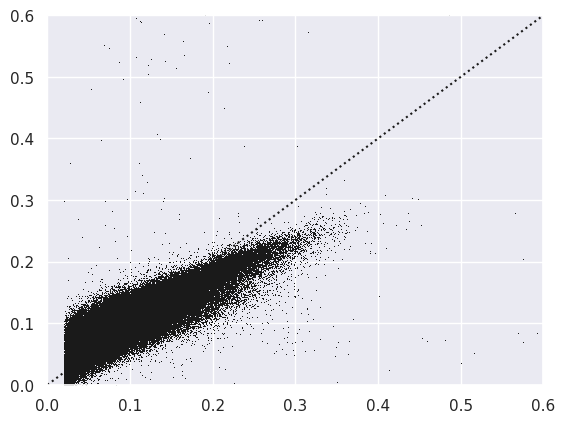

In [25]:
plt.plot(y_test, y_pred, ',k')
plt.plot([0, 1], [0, 1], ':k')
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)

Evidently, a simple linear model is not a very good fit!

Let's compute the RMS deviation to see how poor this actually is:

In [26]:
rms = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(rms)

0.03265444


### Regression Exercise

Try to improve on this result using another regression algorithm.  Some potential choices:

- ``sklearn.neighbors.KNeighborsRegressor`` (fast-ish, but often inaccurate)
- ``sklearn.svm.SVR`` (potentially accurate, but slow)
- ``sklearn.ensemble.RandomForestRegressor`` (fast, and accurate when well-tuned)
- ``sklearn.ensemble.GradientBoostingRegressor`` (accurate with tuning, can be very slow depending on parameters)

Again, sub-sampling the data can help as you explore some of the slower techniques.

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Use a question mark in IPython to find help:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the 